# Dealing with Vanishing/Exploding Gradients in PyTorch

In this chapter we demonstrate that the sigmoid activation function is one of the major sources of the vanishing gradient problem and we show that ReLU can combat the problem. Additionally we show how you can implement weight initialization and clip gradients in PyTorch.

In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import MNIST
from torchvision import transforms as T
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

## ReLU Activation Function

The initial part of this notebook is as expected. We create datasets, dataloaders and functions that are reusable for training and performance measurement purposes.

In [2]:
train_validation_dataset = MNIST(root="../datasets/", train=True, download=True, transform=T.ToTensor())
test_dataset = MNIST(root="../datasets", train=False, download=False, transform=T.ToTensor())

In [3]:
stratify = train_validation_dataset.targets.numpy()
train_idxs, val_idxs = train_test_split(
                                range(len(train_validation_dataset)),
                                stratify=stratify,
                                test_size=0.1)

In [4]:
train_dataset = Subset(train_validation_dataset, train_idxs)
val_dataset = Subset(train_validation_dataset, val_idxs)

In [5]:
# parameters
DEVICE = ("cuda:0" if torch.cuda.is_available() else "cpu")
NUM_EPOCHS=30
BATCH_SIZE=32
NUM_LABELS = 10
NUM_FEATURES = 28*28
HIDDEN = 50
ALPHA = 0.01

In [6]:
train_dataloader = DataLoader(dataset=train_dataset, 
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              drop_last=True,
                              num_workers=4)

val_dataloader = DataLoader(dataset=val_dataset, 
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              drop_last=False,
                              num_workers=4)

test_dataloader = DataLoader(dataset=test_dataset, 
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              drop_last=False,
                              num_workers=4)

In [7]:
def track_performance(dataloader, model, criterion):
    # switch to evaluation mode
    model.eval()
    num_samples = 0
    num_correct = 0
    loss_sum = 0
    
    # no need to calculate gradients
    with torch.inference_mode():
        for batch_idx, (features, labels) in enumerate(dataloader):
            features = features.view(-1, NUM_FEATURES).to(DEVICE)
            labels = labels.to(DEVICE)
            logits = model(features)
            
            predictions = logits.max(dim=1)[1]
            num_correct += (predictions == labels).sum().item()
            
            loss = criterion(logits, labels)
            loss_sum += loss.cpu().item()
            num_samples += len(features)
    
    # we return the average loss and the accuracy
    return loss_sum/num_samples, num_correct/num_samples

In [8]:
def train(train_dataloader, val_dataloader, model, criterion, optimizer):
    # track progress over time
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    for epoch in range(NUM_EPOCHS):
        loss_sum = 0
        batch_nums = 0
        for batch_idx, (features, labels) in enumerate(train_dataloader):
            # switch to training mode
            model.train()
            # move features and labels to GPU
            features = features.view(-1, NUM_FEATURES).to(DEVICE)
            labels = labels.to(DEVICE)

            # ------ FORWARD PASS --------
            probs = model(features)

            # ------CALCULATE LOSS --------
            loss = criterion(probs, labels)

            # ------BACKPROPAGATION --------
            loss.backward()

            # ------GRADIENT DESCENT --------
            optimizer.step()

            # ------CLEAR GRADIENTS --------
            optimizer.zero_grad()

        # ------TRACK LOSS --------
        train_loss, train_acc = track_performance(train_dataloader, model, criterion)
        val_loss, val_acc = track_performance(val_dataloader, model, criterion)
        
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f'Epoch: {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss} | Val Loss: {val_loss}')
    return history

In [9]:
def plot_history(history):
    fig = plt.figure(figsize=(12, 5))

    fig.add_subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Training Loss")
    plt.plot(history["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Cross-Entropy")
    plt.legend()
    
    fig.add_subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Training Accuracy")
    plt.plot(history["val_acc"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.show()

Below we create two models that only differ in their activation functions. The first model uses `nn.Sigmoid` as the activation function, while the second uses `nn.ReLU`. Compared to the models we have seen in the previous sections, the models below have a lot of layers, which should theoretically cause the vanishing gradient problem.

In [10]:
class SigmoidModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(NUM_FEATURES, HIDDEN),
            nn.Sigmoid(),
            nn.Linear(HIDDEN, HIDDEN),
            nn.Sigmoid(),
            nn.Linear(HIDDEN, HIDDEN),
            nn.Sigmoid(),
            nn.Linear(HIDDEN, HIDDEN),
            nn.Sigmoid(),
            nn.Linear(HIDDEN, HIDDEN),
            nn.Sigmoid(),
            nn.Linear(HIDDEN, NUM_LABELS)
        )
        
    def forward(self, features):
        return self.layers(features)
    
class ReluModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(NUM_FEATURES, HIDDEN),
            nn.ReLU(),
            nn.Linear(HIDDEN, HIDDEN),
            nn.ReLU(),
            nn.Linear(HIDDEN, HIDDEN),
            nn.ReLU(),
            nn.Linear(HIDDEN, HIDDEN),
            nn.ReLU(),
            nn.Linear(HIDDEN, HIDDEN),
            nn.ReLU(),
            nn.Linear(HIDDEN, NUM_LABELS)
        )
        
    def forward(self, features):
        return self.layers(features)

The sigmoid model does not train at all. The signal deteriorates and can not propagate to the initial layers.

In [11]:
model = SigmoidModel().to(DEVICE)
criterion = nn.CrossEntropyLoss(reduction="sum")
optimizer = optim.SGD(model.parameters(), lr=ALPHA)

In [12]:
history = train(train_dataloader, val_dataloader, model, criterion, optimizer)

Epoch: 1/30 | Train Loss: 2.305029192264785 | Val Loss: 2.305026891072591
Epoch: 10/30 | Train Loss: 2.303280200630373 | Val Loss: 2.303288656870524
Epoch: 20/30 | Train Loss: 2.3019603394020502 | Val Loss: 2.301950798670451
Epoch: 30/30 | Train Loss: 2.3065965923248273 | Val Loss: 2.3065873584747316


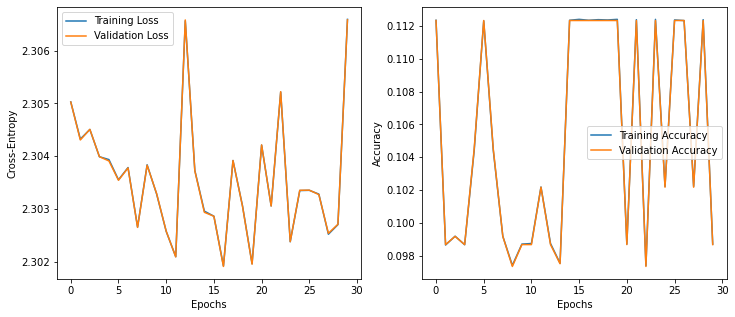

In [13]:
plot_history(history)

The ReLU model on the other hand trains just fine. While there seems to be overfitting, the model manages to keep the signal flowing to the initial layers.

In [14]:
model = ReluModel().to(DEVICE)
criterion = nn.CrossEntropyLoss(reduction="sum")
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [15]:
history = train(train_dataloader, val_dataloader, model, criterion, optimizer)

Epoch: 1/30 | Train Loss: 0.20872536998945462 | Val Loss: 0.2180664131467541
Epoch: 10/30 | Train Loss: 0.06277150359708887 | Val Loss: 0.13648133039443444
Epoch: 20/30 | Train Loss: 0.0350863564896757 | Val Loss: 0.122164350196952
Epoch: 30/30 | Train Loss: 0.025143898080912504 | Val Loss: 0.14567846053010242


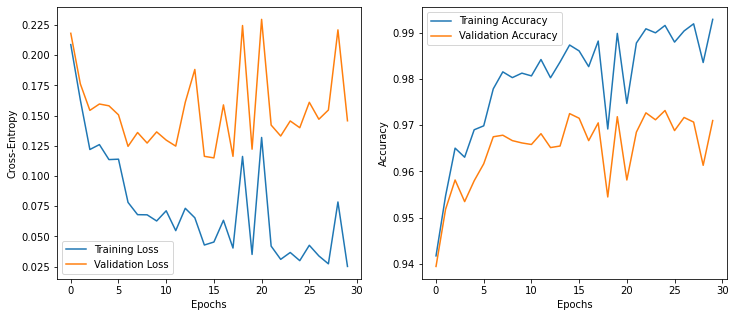

In [16]:
plot_history(history)

## Weight Initialization

When we use the `nn.Linear` module, PyTorch automatically initializes weights and biases using the Kaiming He uniform initialization scheme. So when the sigmoid model above was not able to perform well, this might have been caused by the wrong initialization. The Kaiming He initialization was developed for ReLU, while the Glorot Xavier initialization should be used with sigmoid activation functions.

PyTorch provides in `nn.init` different functions that can be used to initialize a tensor. Below for example we use the Kaiming unifor initialization on an empty tensor. You should notice that the initialization is done inplace.

In [17]:
W = torch.empty(5, 5)
# initializations are defined in nn.init
nn.init.kaiming_uniform_(W)

tensor([[ 0.7405,  0.9369, -0.2068,  0.6445, -0.3428],
        [ 0.4251, -0.2240,  0.3274, -0.5257,  0.5309],
        [ 0.6062, -0.3549,  0.2259,  0.8739,  0.4439],
        [-0.5818, -0.4352, -1.0670, -0.6694, -0.2279],
        [-1.0333, -0.7423, -0.8578,  1.0642,  0.0165]])

We once again create the same model that uses sigmoid activation functions. Only this time we loop over weights and biases and use the Xavier uniform initialization for weights and we set all biases to 0 at initialization.

In [18]:
class SigmoidModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(NUM_FEATURES, HIDDEN),
            nn.Sigmoid(),
            nn.Linear(HIDDEN, HIDDEN),
            nn.Sigmoid(),
            nn.Linear(HIDDEN, HIDDEN),
            nn.Sigmoid(),
            nn.Linear(HIDDEN, HIDDEN),
            nn.Sigmoid(),
            nn.Linear(HIDDEN, HIDDEN),
            nn.Sigmoid(),
            nn.Linear(HIDDEN, NUM_LABELS)
        )
        
        self.reset_parameters()
        
    def reset_parameters(self):
        with torch.inference_mode():
            for param in self.parameters():
                if param.ndim > 1:
                    nn.init.xavier_uniform_(param, 1)
                else:
                    param.zero_()
            
    def forward(self, features):
        return self.layers(features)

This time the model has no problems training. 

In [19]:
model = SigmoidModel().to(DEVICE)
criterion = nn.CrossEntropyLoss(reduction="sum")
optimizer = optim.SGD(model.parameters(), lr=ALPHA)

In [20]:
history = train(train_dataloader, val_dataloader, model, criterion, optimizer)

Epoch: 1/30 | Train Loss: 2.302951812178833 | Val Loss: 2.302955456415812
Epoch: 10/30 | Train Loss: 0.28798940064298306 | Val Loss: 0.308363536943992
Epoch: 20/30 | Train Loss: 0.08930828344453928 | Val Loss: 0.15924451432873804
Epoch: 30/30 | Train Loss: 0.04866997841970579 | Val Loss: 0.14407004518589625


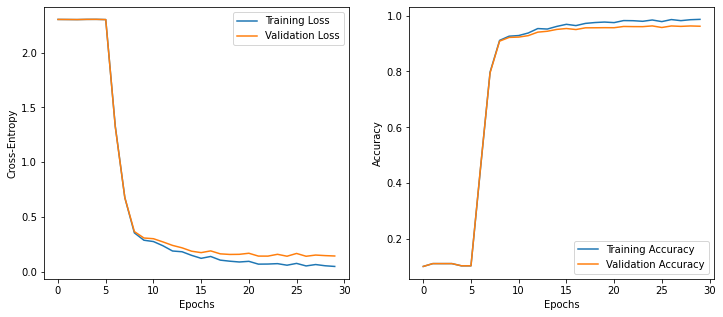

In [21]:
plot_history(history)

## Gradient Clipping

Implementing gradient clipping is extremely easy in PyTorch. All you have to do is to call `nn.utils.clip_grad_norm_` and provide the parameters of the model. The underline in the name of the function suggest that the clipping is done inplace. You should call this function just before you call `optimizer.step`. That way gradient descent is conducted with clipped weights.

In [22]:
nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

tensor(0., device='cuda:0')